<h2> 6. Bayes Classification </h2>

This notebook has the code for the charts in Chapter 6


<h3> Exploration using BigQuery </h3>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datalab.bigquery as bq

In [3]:
sql = """
SELECT DISTANCE, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001 AND dep_delay > -20 AND dep_delay < 30 AND distance < 2000
"""
df = bq.Query(sql).to_dataframe(dialect='standard')

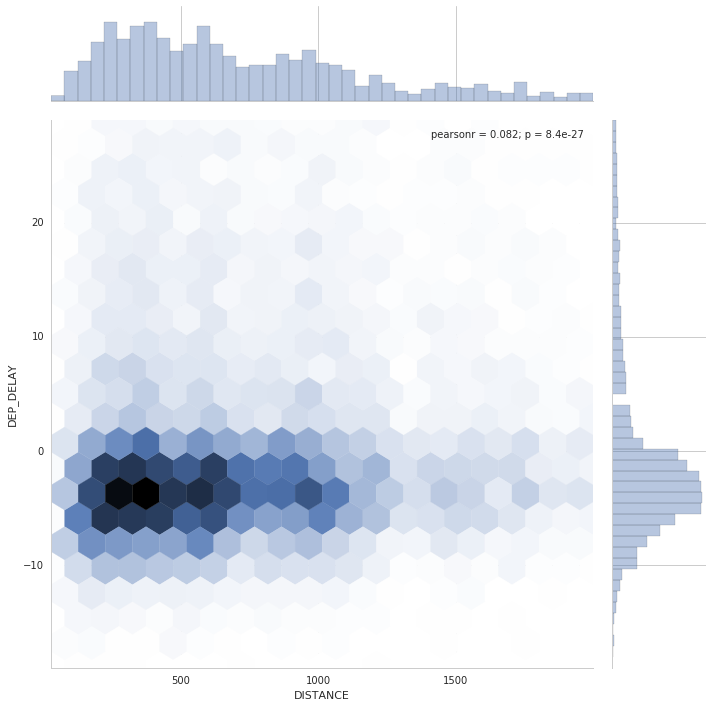

In [4]:
sns.set_style("whitegrid")
g = sns.jointplot(df['DISTANCE'], df['DEP_DELAY'], kind="hex", size=10, joint_kws={'gridsize':20})

<h3> Exploration using Spark SQL </h3>

Note that a SparkSession object already exists in Datalab:

In [6]:
print spark

In a standalone script, we'd have to do:
<pre>
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Bayes classification using Spark") \
    .getOrCreate()
</pre>

Set up the schema to read in the CSV files on GCS

In [9]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])
print schema

StructType(List(StructField(FL_DATE,StringType,true),StructField(UNIQUE_CARRIER,StringType,true),StructField(AIRLINE_ID,StringType,true),StructField(CARRIER,StringType,true),StructField(FL_NUM,StringType,true),StructField(ORIGIN_AIRPORT_ID,StringType,true),StructField(ORIGIN_AIRPORT_SEQ_ID,StringType,true),StructField(ORIGIN_CITY_MARKET_ID,StringType,true),StructField(ORIGIN,StringType,true),StructField(DEST_AIRPORT_ID,StringType,true),StructField(DEST_AIRPORT_SEQ_ID,StringType,true),StructField(DEST_CITY_MARKET_ID,StringType,true),StructField(DEST,StringType,true),StructField(CRS_DEP_TIME,StringType,true),StructField(DEP_TIME,StringType,true),StructField(DEP_DELAY,FloatType,true),StructField(TAXI_OUT,StringType,true),StructField(WHEELS_OFF,StringType,true),StructField(WHEELS_ON,StringType,true),StructField(TAXI_IN,StringType,true),StructField(CRS_ARR_TIME,StringType,true),StructField(ARR_TIME,StringType,true),StructField(ARR_DELAY,FloatType,true),StructField(CANCELLED,StringType,true)

Create a table definition (this is done lazily; the files won't be read until we issue a query):

In [24]:
flights = spark.read\
            .schema(schema)\
            .csv('gs://cloud-training-demos-ml/flights/tzcorr/all_flights-*')  # all_flights-000*

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

Example query over the view:

In [25]:
results = spark.sql('SELECT COUNT(*) FROM flights WHERE dep_delay > -20 AND distance < 300')
results.show()

+--------+
|count(1)|
+--------+
| 1181815|
+--------+



Repeat what we did in BQ, but notice that because we are using a Spark Dataframe rather than a Pandas dataframe, we don't need to do RAND() < 0.001

In [26]:
df = spark.sql('SELECT distance, dep_delay FROM flights WHERE (dep_delay > -20) AND (dep_delay < 30) AND (distance < 2000)')
df.describe().show()

+-------+-----------------+-------------------+
|summary|         distance|          dep_delay|
+-------+-----------------+-------------------+
|  count|          5837373|            5837373|
|   mean|712.3219417364626|-0.3161343296034021|
| stddev|442.3724766198282|  8.180764339643494|
|    min|             30.0|              -19.0|
|    max|           1999.0|               29.0|
+-------+-----------------+-------------------+



Sample the dataframe so that it fits into memory; then plot it.

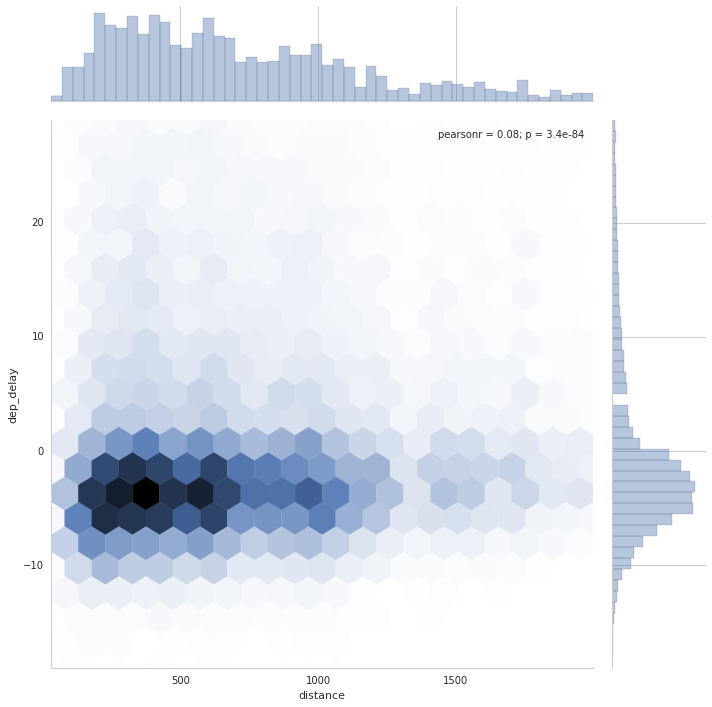

In [27]:
pdf = df.sample(False, 0.05, 20).toPandas()
g = sns.jointplot(pdf['distance'], pdf['dep_delay'], kind="hex", size=10, joint_kws={'gridsize':20})

<h3> Quantization using Spark SQL </h3>

Now find the quantiles

In [29]:
distthresh = flights.approxQuantile('DISTANCE', [0.2, 0.4, 0.6, 0.8], 0.05)
distthresh

[316.0, 572.0, 907.0, 1258.0]

In [33]:
nonulls = spark.sql('SELECT dep_delay FROM flights WHERE dep_delay IS NOT NULL')
delaythresh = nonulls.approxQuantile('dep_delay', [0.2, 0.4, 0.6, 0.8], 0.05)
delaythresh

[-4.0, -2.0, 2.0, 22.0]